In [12]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm

sys.path.insert(0, '../Modules')
import erqScaling
import erqMedSpec
import os

In [13]:
# Reading data
smp=Table.read('../LumMatch/LumMatch.fits')


iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
rw3_0=smp['r-w3']
rz_0=smp['r-z']
iz_0 = iW3_0 - rw3_0 + rz_0
Lum_0 = smp['Lum']
z_dr12 = smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiber =  smp['FiberID']
X_0=np.array(list(zip(iW3_0, rew_0)))
# (X_scaled, mean_X, std_X) = scale(X_0)
# X, m, r =erqScaling.MinMaxScaler(X_0)
X = X_0
x_erq =  4.6  #(4.6-np.min(iW3_0))/(np.max(iW3_0)-np.min(iW3_0))
y_erq = 2  #(2- np.min(rew_0))/(np.max(rew_0)-np.min(rew_0))
Main_center = np.median(X, axis=0)
ERQ= X[(iW3_0>=x_erq) & (rew_0>=y_erq)]

print(Main_center)

[2.48746144 1.55517281]


100%|██████████| 20/20 [00:01<00:00, 11.64it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 23/23 [00:02<00:00, 11.26it/s]


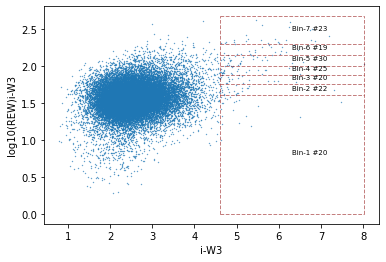

In [60]:
#  Med-Spec strip -> rew
x0=4.6
dir = 'outData/strip-rew/%.2f' %(x0)
os.system('mkdir -p ' + dir)
x_max = np.max(iW3_0)
y_max = np.max(rew_0)+0.05
y0 = [0, 1.6, 1.75, 1.88, 2, 2.15, 2.3, y_max]
plt.scatter(iW3_0, rew_0, s=0.1)
plt.plot([x0,x0],[y0[0],y_max], lw=1,alpha=0.5, c='darkred', ls='--')
for i in range(len(y0)-1):
        
        mask = ((iW3_0>=x0) & (rew_0>y0[i]) & (rew_0<y0[i+1]))
        medSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiber[mask])
        np.savetxt(dir+ '/Bin-rew-%d-Mask.txt' %(i+1), mask, fmt= '%d')
        np.savetxt(dir+'/med-spec-strip-rew-bin-%d.txt' %(i+1), medSpec)
        plt.plot([x0,x_max],[y0[i],y0[i]], c='darkred', lw=1, alpha=0.5, ls='--')
        plt.text((x_max+4.6)/2,(y0[i]+y0[i+1])/2, 'Bin-%d #%d' %(i+1,sum(mask==True)), fontsize=7, c='black')
    

plt.plot([x0,x_max], [y_max,y_max], c='darkred', lw=1, alpha=0.5, ls='--')
plt.plot([x_max,x_max],[y0[0],y_max], c='darkred', lw=1, alpha=0.5, ls='--')
plt.xlabel('i-W3')
plt.ylabel('log10(REW)i-W3')
#      plotting Strips
plt.savefig(dir+'/strips-rew.png', dpi=200, bbox_inches='tight', format='png')
plt.show()

In [77]:
# Plotting Spectra -> REW
#  PLotting
from line_db import line_db
from matplotlib import cm
from scipy import ndimage

# c = cm.get_cmap('coolwarm', 7)
c=['gray', 'red', 'green', 'black' ]
ymax=32



ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7

# -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)

#  Median properties in each bin
rew_0 = smp['rew_gf']


imw3_bin_med =[]
REW_bin_med = []
fwhm_bin_med = []
kt80_bin_med = []
frat_bin_med = []
iz_bin_med = []
Lum_bin_med = []
Bin=[]
BinPop=[]
for b in range(1,len(y0)):
    mask = np.loadtxt(dir+'/Bin-rew-%d-Mask.txt' %(b))
    BinPop.append(sum(mask==True))
    Bin.append("{0:.0f}".format(b))
    imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask==True])))
    REW_bin_med.append("{0:.0f}".format(np.median(rew_0[mask==True])))
    fwhm_bin_med.append("{0:.0f}".format(np.median(fwhm_0[mask==True])))
    kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask==True])))
    frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask==True])))
    iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask==True])))
    Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask==True])))

tabProperties = Table([Bin,BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med],
                      names=('Bin','nBin', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))
if os.path.exists(dir+ '/Strip-rew-Properties.fits'):
    os.system('rm '+ dir+'/Strip-rew-Properties.fits')
tabProperties.write(dir+ '/Strip-rew-Properties.fits' , format='fits')

R, B- 1 1000 to 1980
R, B- 2 1000 to 1980
R, B- 3 1000 to 1980
R, B- 4 1000 to 1980
R, B- 5 1000 to 1980
R, B- 6 1000 to 1980
R, B- 7 1000 to 1980


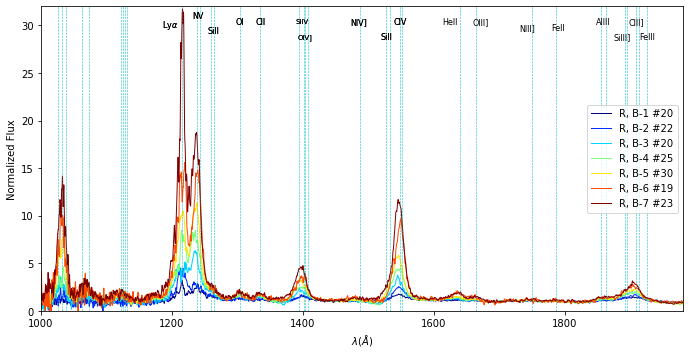

R, B- 1 1150 to 1980
R, B- 2 1150 to 1980
R, B- 3 1150 to 1980
R, B- 4 1150 to 1980
R, B- 5 1150 to 1980
R, B- 6 1150 to 1980
R, B- 7 1150 to 1980


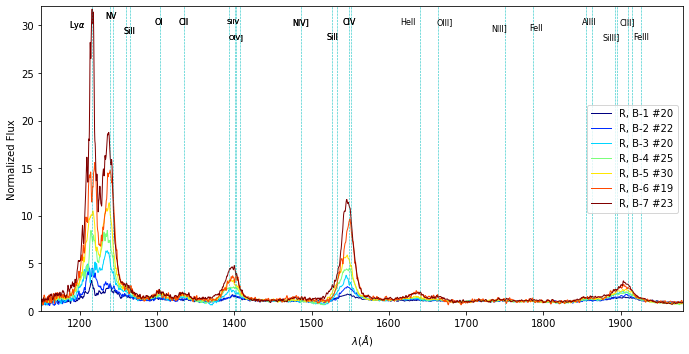

R, B- 1 1150 to 2850
R, B- 2 1150 to 2850
R, B- 3 1150 to 2850
R, B- 4 1150 to 2850
R, B- 5 1150 to 2850
R, B- 6 1150 to 2850
R, B- 7 1150 to 2850


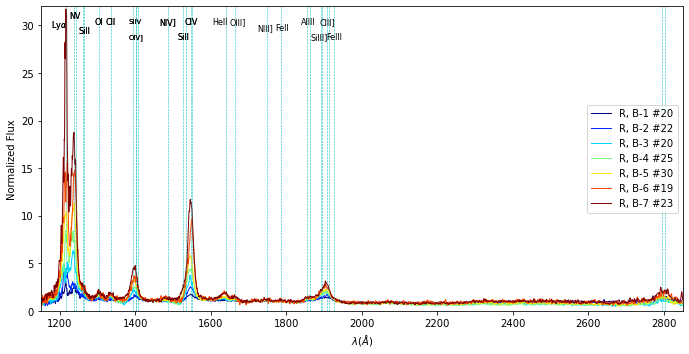

R, B- 1 1150 to 1700
R, B- 2 1150 to 1700
R, B- 3 1150 to 1700
R, B- 4 1150 to 1700
R, B- 5 1150 to 1700
R, B- 6 1150 to 1700
R, B- 7 1150 to 1700


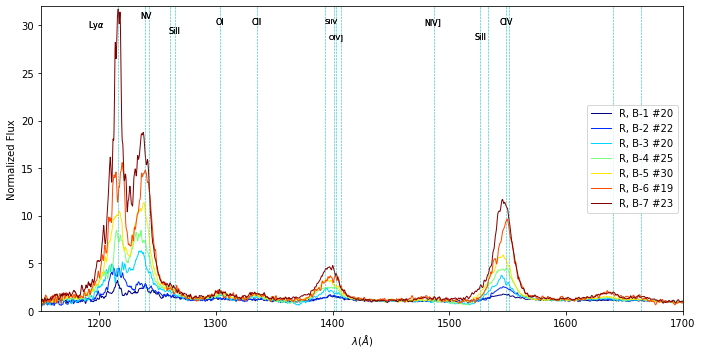

In [78]:
c = cm.get_cmap('jet', 7)
for ii in range(4):

    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    line_db(ymax, fs, fs1, lambda_max)

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200

    for b in range(1,len(y0)):
        print('R, B-', b, lambda_min, 'to', lambda_max)
        medSpec=np.loadtxt(dir+'/med-spec-strip-rew-bin-%d.txt' %(b))
        plt.ylabel('Normalized Flux')
        plt.xlabel(r'$\lambda  (\AA)$')


        if(BinPop[b-1]<100):
            SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
        else:
            SmoothedMedSpec = medSpec

        # masking for plot ranges
        ind = (wgrid>lambda_min) & (wgrid<lambda_max)
        plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 1, c=c(b-1), 
                     label='R, B-%d #%d' %(b, BinPop[b-1]))




    plt.legend(loc=7)

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-strip-rew.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=200, bbox_inches='tight')
    plt.show()

In [79]:
a = np.arange(10)

In [80]:
np.random.choice(a, 10, replace=True)

array([7, 7, 9, 9, 1, 7, 4, 5, 5, 6])

In [81]:
np.random.choice(a, 10, replace=True)

array([4, 8, 7, 2, 1, 3, 1, 9, 6, 5])

In [82]:
np.random.choice(a, 10, replace=True)

array([4, 9, 5, 8, 1, 0, 0, 4, 0, 7])

In [85]:
np.random.choice(a, 11, replace=True)

array([9, 1, 9, 0, 6, 8, 3, 6, 9, 2, 8])